# Step 1:
- Mount Google Drive
- import libraries
- import packages
- set up the working directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install "dask[distributed]" --upgrade

In [3]:
!pip install seaborn

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from dask.distributed import Client
import dask.dataframe as dd



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Step 2: Define Feature Extraction Function
- Purpose: Define a function to filter and visualize features based on a correlation threshold.
- Explanation: This function calculates the correlation matrix of the input DataFrame, identifies highly correlated features, separates them into selected and excluded features, and visualizes the correlation matrices.
Cell


## Explaintion
- The correlation matrix help to unterstand how each feature relates to every other feature in the data set. The values ranging from -1 to 1, where 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation and
0 indicates no correlation.
- identifying highly correlated festures through the upper triangular matrix of the correlation matrix (excluding the diagonal) to find pairs of features with a correlation higher than a specified threshold (0.9 by default). These highly correlated features are marked for exclusion.
- filtering selected and excluded features in two list, where
  - selected_features: Features with correlation below the threshold.
  - excluded_features: Features with correlation above the threshold


In [5]:
def extractor(df, threshold=0.9):
    """
    ************************************************************************
    EXPLANATIONS

    Filter features based on correlation threshold and visualize the correlation matrices.

    In practice a threshold of 0.9 is widespread but there exists more conservatve
    thresholds like 0.8 which is a more conservative approach. You may choose it
    depending on the context.

    ************************************************************************

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the features.
    threshold (float): The correlation threshold to filter features. Default is 0.9.

    Returns:
    selected_features (list): List of features with correlation below the threshold.
    excluded_features (list): List of features with correlation above the threshold.
    """

      # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Create lists for selected features ("normal correlations") and excluded features (perfectly/almost perfectly correlated)
    selected_features = []
    excluded_features = []

    # Run through the upper triangular matrix of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                excluded_features.append(colname)

    # fill lists of excluded and selected features
    excluded_features = list(set(excluded_features))
    selected_features = [feature for feature in corr_matrix.columns if feature not in excluded_features]

    # create correlation matrix of selected features
    selected_corr_matrix = corr_matrix.loc[selected_features, selected_features]

    # plot correlation matrix of selected features
    plt.figure(figsize=(12, 10))
    sns.heatmap(selected_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Selected Features')
    plt.show()

    # create correlation matrix of excluded features and plot it
    if excluded_features:
        remaining_corr_matrix = corr_matrix.loc[excluded_features, excluded_features]
        plt.figure(figsize=(20, 16))
        sns.heatmap(remaining_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Correlation Matrix of Excluded Features')
        plt.show()
    else:
        print("No excluded features found.")

    # print lists of selected/excluded features
    print("Selected Features:", selected_features)
    print("Excluded Features:", excluded_features)


    # return lists of selected and excluded features
    return selected_features, excluded_features



#Step 3: Load the data set and show feature of the data
- Load datasets from CSV files.
- Print the shape of the dataset and select specific columns
- Apply the extractor function to filter and visualize the selected features that were selected in the previous step
  - correlation matrix of selected features visualized in heatmaps and shows the features that are not highly correlated with each other
    - helps helps in identifying features that are not redundant and can provide unique information for model building
  - correlation matrix matrix of excluded featrues visualized in heatmaps and show the features that are highly correlated with at least one other feature
    - These features are considered redundant because they provide similar information, and including all of them might not improve the model's performance but can increase computational complexity.
  - list of selected and excluted features
    - Displays the correlation matrix of features that are not highly correlated (correlation < 0.9)
    - Displays the correlation matrix of features that are highly correlated (correlation > 0.9).

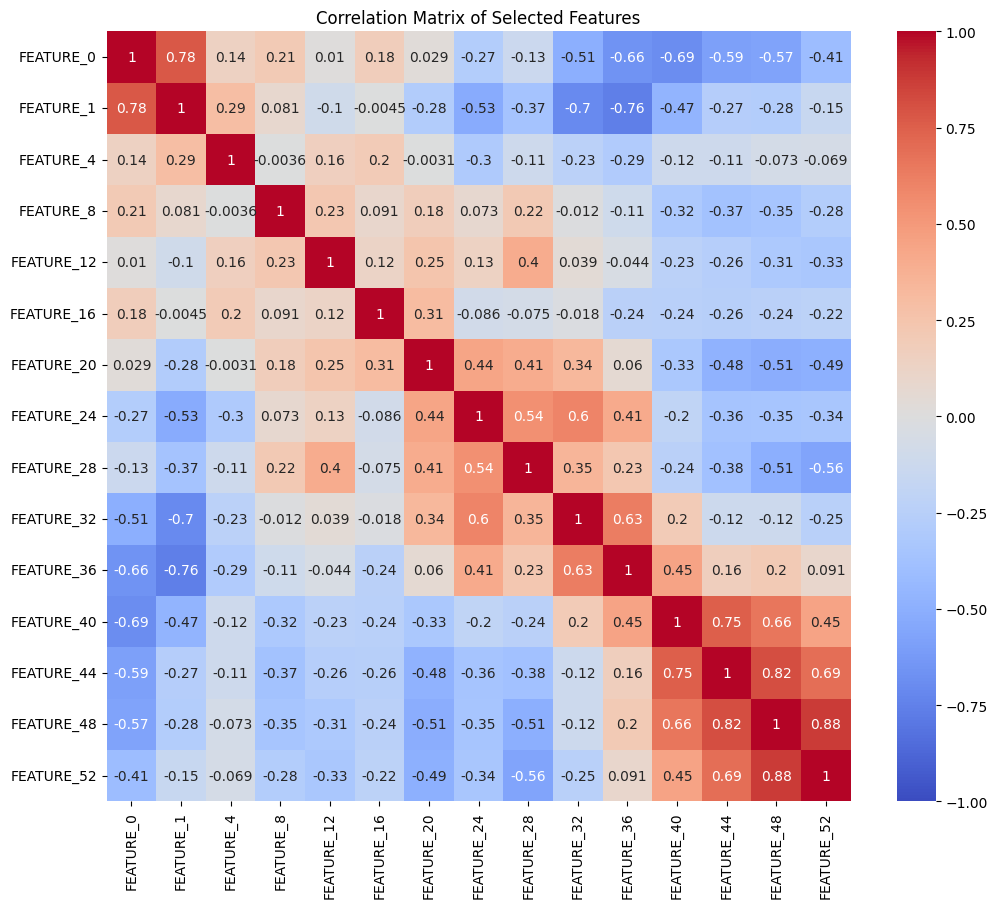

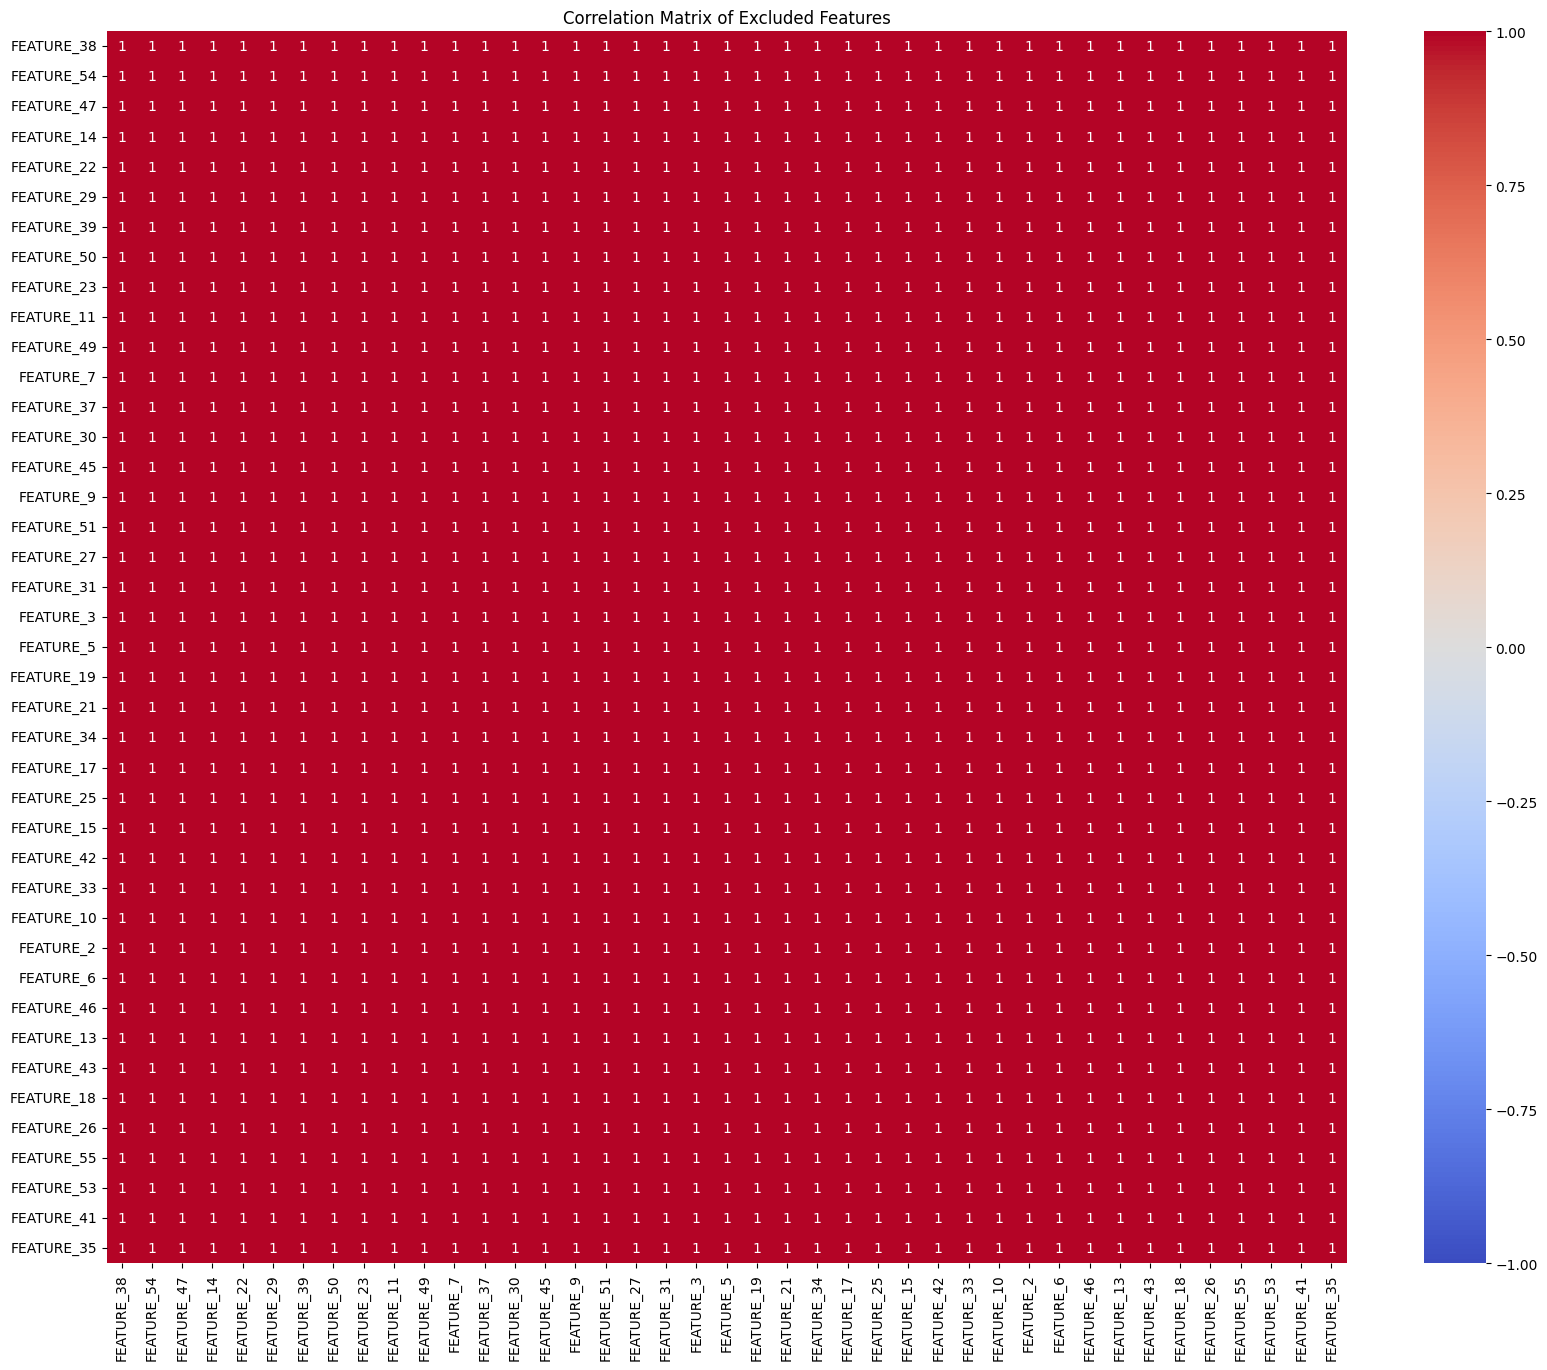

Selected Features: ['FEATURE_0', 'FEATURE_1', 'FEATURE_4', 'FEATURE_8', 'FEATURE_12', 'FEATURE_16', 'FEATURE_20', 'FEATURE_24', 'FEATURE_28', 'FEATURE_32', 'FEATURE_36', 'FEATURE_40', 'FEATURE_44', 'FEATURE_48', 'FEATURE_52']
Excluded Features: ['FEATURE_38', 'FEATURE_54', 'FEATURE_47', 'FEATURE_14', 'FEATURE_22', 'FEATURE_29', 'FEATURE_39', 'FEATURE_50', 'FEATURE_23', 'FEATURE_11', 'FEATURE_49', 'FEATURE_7', 'FEATURE_37', 'FEATURE_30', 'FEATURE_45', 'FEATURE_9', 'FEATURE_51', 'FEATURE_27', 'FEATURE_31', 'FEATURE_3', 'FEATURE_5', 'FEATURE_19', 'FEATURE_21', 'FEATURE_34', 'FEATURE_17', 'FEATURE_25', 'FEATURE_15', 'FEATURE_42', 'FEATURE_33', 'FEATURE_10', 'FEATURE_2', 'FEATURE_6', 'FEATURE_46', 'FEATURE_13', 'FEATURE_43', 'FEATURE_18', 'FEATURE_26', 'FEATURE_55', 'FEATURE_53', 'FEATURE_41', 'FEATURE_35']


(['FEATURE_0',
  'FEATURE_1',
  'FEATURE_4',
  'FEATURE_8',
  'FEATURE_12',
  'FEATURE_16',
  'FEATURE_20',
  'FEATURE_24',
  'FEATURE_28',
  'FEATURE_32',
  'FEATURE_36',
  'FEATURE_40',
  'FEATURE_44',
  'FEATURE_48',
  'FEATURE_52'],
 ['FEATURE_38',
  'FEATURE_54',
  'FEATURE_47',
  'FEATURE_14',
  'FEATURE_22',
  'FEATURE_29',
  'FEATURE_39',
  'FEATURE_50',
  'FEATURE_23',
  'FEATURE_11',
  'FEATURE_49',
  'FEATURE_7',
  'FEATURE_37',
  'FEATURE_30',
  'FEATURE_45',
  'FEATURE_9',
  'FEATURE_51',
  'FEATURE_27',
  'FEATURE_31',
  'FEATURE_3',
  'FEATURE_5',
  'FEATURE_19',
  'FEATURE_21',
  'FEATURE_34',
  'FEATURE_17',
  'FEATURE_25',
  'FEATURE_15',
  'FEATURE_42',
  'FEATURE_33',
  'FEATURE_10',
  'FEATURE_2',
  'FEATURE_6',
  'FEATURE_46',
  'FEATURE_13',
  'FEATURE_43',
  'FEATURE_18',
  'FEATURE_26',
  'FEATURE_55',
  'FEATURE_53',
  'FEATURE_41',
  'FEATURE_35'])

In [6]:
# Load the different datasets always activate only one and change title results accordingly

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100.csv')
# data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_17_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100.csv')


#keep track which threshold and version to save results correctly.
title_results = "TH2_BP_PHQ_2"
#title_results = "TH17_MH_PHQ_S"

columns_with_features = [col for col in data.columns if "FEATURE" in col]

extractor(data[columns_with_features])


# Step 4: Explanation of Defining Data and Target for the Training Process
- Define Features (X)
 - line selects the columns that are identified as important features for the model
 - The DataFrame data1 contains all the data, and by specifying the column names in double square brackets, you are creating a new DataFrame X that includes only the selected feature columns. These columns were identified previously as the selected features that are not highly correlated.

- Define Target Variable (y)
  - line selects the target variable
  - The column 'Depression' from the DataFrame data is assigned to the variable y. This column represents the labels or outcomes that correspond to each row of features in X.

- Print First Few Rows of Features: Prints the first few rows of X to check the data.
- Print Shape of Features: Prints the dimensions of X to understand the dataset size.

In [7]:
# Define Data and Target for the training process

X = data[['FEATURE_0', 'FEATURE_1', 'FEATURE_4', 'FEATURE_8', 'FEATURE_12', 'FEATURE_16', 'FEATURE_20', 'FEATURE_24', 'FEATURE_28', 'FEATURE_32', 'FEATURE_36', 'FEATURE_40', 'FEATURE_44', 'FEATURE_48', 'FEATURE_52']]
y = data['Depression']
print(X.head)
print(X.shape)

<bound method NDFrame.head of      FEATURE_0  FEATURE_1  FEATURE_4  FEATURE_8  FEATURE_12  FEATURE_16  \
0     6.769834  -0.319559  -0.280888  -0.212718    0.223368    0.208923   
1     4.855263  -0.438780  -0.438823  -0.333889   -0.302499    0.588967   
2     4.786821  -0.436577  -0.347784  -0.230345   -0.179782    0.689279   
3     4.185324  -0.432203  -0.425526   0.056293   -0.279408    0.908803   
4     4.789679  -0.450950  -0.439212  -0.353679    0.050581    0.808610   
..         ...        ...        ...        ...         ...         ...   
635   4.924071  -0.407955  -0.372306  -0.399525    0.041994    0.210757   
636   5.851797  -0.383768  -0.383739  -0.338778   -0.287039    0.667006   
637   3.579501  -0.421611  -0.401714  -0.376635   -0.235264   -0.002617   
638   4.991720  -0.423239  -0.422916  -0.129807    0.068608   -0.225763   
639   4.151211  -0.424411  -0.285593  -0.411741   -0.107482    0.100864   

     FEATURE_20  FEATURE_24  FEATURE_28  FEATURE_32  FEATURE_36  FEAT

# Step 5: Split the Data


- Split the Data: Divide the dataset into training and testing sets to evaluate the model's performance on unseen data. Split the dataset into training (80%) and testing (20%) sets.


In [8]:
# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=14)

# Step 6: Best Parameters from Hyperparameter Tuning

- Define Parameter Grid: Define the range of hyperparameters for Randomized Search.
- Initialize Classifier: Initialize the Random Forest classifier.
- Randomized Search: Set up and fit RandomizedSearchCV to find the best hyperparameters.
- Print Best Parameters: Print the best parameters found
- Fit the Model: Perform the hyperparameter tuning process and fit the model to the training data.

In [9]:
# Define the parameter grid for Randomized Search
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Set up the RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                               n_iter=100, cv=3, verbose=2, random_state=14, n_jobs=-1)

# Fit the model
rf_random.fit(train_X, train_y)

# Check the best parameters and score
best_params = rf_random.best_params_
best_score = rf_random.best_score_
print("Best Parameters:", best_params)
print("Best parameters found: ", rf_random.best_params_)

# Create the Random Forest classifier with the best parameters obtained from hyperparameter tuning
RF = RandomForestClassifier(**best_params)

# Print the best parameters
print("Using the following parameters for the Random Forest classifier:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Best parameters found:  {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Using the following parameters for the Random Forest classifier:
n_estimators: 600
min_samples_split: 2
min_samples_leaf: 1
max_features: sqrt
max_depth: 20
bootstrap: True


#Step 7: Training a Random Forest Classifier and Evaluating Its Performance
- Create the Random Forest Classifier: Instantiate the classifier with the specific hyperparameters that were identified as the best during hyperparameter tuning. This ensures that the classifier is configured optimally for the given data.

- Fit the Model on the Training Data: Train the Random Forest classifier using the training data. The model learns from the training data to build decision trees and make predictions.

- Make Predictions on the Training Data: Generate predictions for the training data using the trained model. This step helps to evaluate how well the model has learned from the training data.

- Calculate the Precision Score: Compute and print the precision score to evaluate the model's accuracy in predicting positive outcomes. Precision is the ratio of true positive predictions to the sum of true positive and false positive predictions, measuring the accuracy of positive predictions.

- Generate and Display the Confusion Matrix:
Visualize the classifier's performance using a confusion matrix. This matrix shows the distribution of true positives, true negatives, false positives, and false negatives, providing insight into the model's prediction errors and successes.

- Make Predictions on the Test Data: Generate predictions for the test data using the trained model. This step is crucial to assess how well the model generalizes to new, unseen data.

- Calculate the Precision Score for Test Data: Compute and print the precision score for the test data. This evaluates the model's accuracy in predicting positive outcomes on unseen data, indicating its real-world performance.

- Calculate the Mean Squared Error: Compute and print the mean squared error (MSE) for the test data. MSE calculates the average squared difference between the actual and predicted values, providing a measure of the model's overall prediction error.

- Generate and Display the Confusion Matrix for Test Data: Visualize the classifier's performance on the test data using a confusion matrix. This helps to understand how well the model performs in distinguishing between classes in new data.





Precision Score on training data: 1.0


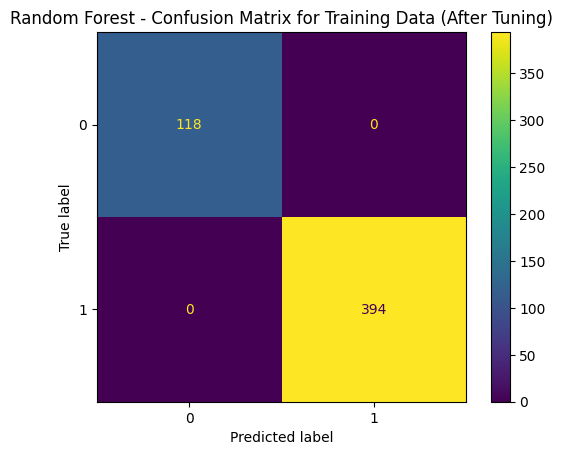

Precision Score on test data: 0.7873865511551155
Mean Squared Error: 0.2109375


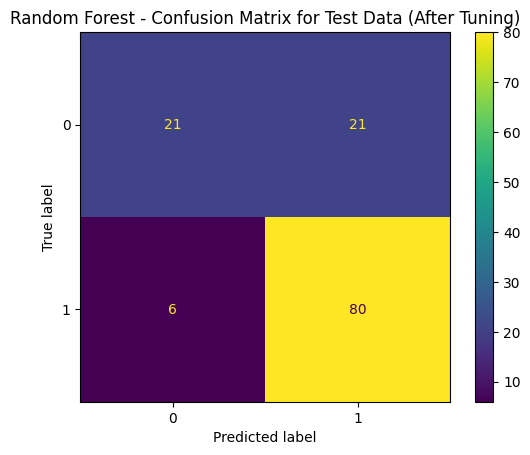

In [10]:
# Fit the model on the training data
RF.fit(train_X, train_y)

# Make predictions on the training data
pred_y_train = RF.predict(train_X)

# Calculate the precision score for training data
precision_train = precision_score(train_y, pred_y_train, average='weighted')
print(f"Precision Score on training data: {precision_train}")

# Generate and display the confusion matrix for training data
cm_train = confusion_matrix(train_y, pred_y_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title('Random Forest - Confusion Matrix for Training Data (After Tuning)')
plt.show()

# Make predictions on the test data
pred_y_test = RF.predict(test_X)

# Calculate the precision score for test data
precision_test = precision_score(test_y, pred_y_test, average='weighted')
print(f"Precision Score on test data: {precision_test}")

# Calculate the Mean Squared Error for test data
mse = mean_squared_error(test_y, pred_y_test)
print(f"Mean Squared Error: {mse}")

# Generate and display the confusion matrix for test data
cm_test = confusion_matrix(test_y, pred_y_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title('Random Forest - Confusion Matrix for Test Data (After Tuning)')
plt.show()

# Step 8: Calculate Accuracy, Precision, Recall, False Negative Rate, and F1 Score
  - Extract True Negative, False Positive, False Negative, and True Positive: Extract the components of the confusion matrix to compute various evaluation metrics.

  
  - Accuracy: Measures the overall correctness of the model. High accuracy is desired but can be misleading in imbalanced datasets.
  - Precision: Measures the accuracy of positive predictions. High precision means fewer false positives.
  - Recall: Measures the ability to identify positive instances. High recall means fewer false negatives.
  - F1 Score: Balances precision and recall, providing a single metric that considers both. Useful in scenarios with imbalanced datasets or when both false positives and false negatives are important.

- Print the Calculated Metrics:
Display the computed metrics for a comprehensive assessment of the classifier's performance. This step provides a detailed understanding of the model's strengths and weaknesses in predicting both positive and negative instances.

In [11]:
# Extract True Negative, False Positive, False Negative, and True Positive
TN, FP, FN, TP = cm_test.ravel()

# Calculate accuracy, recall, false negative rate, and F1 score
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)  # True positive rate
FNR = FN / (TP + FN)  # False negative rate
f1 = 2 * (precision_test * recall) / (precision_test + recall)  # Use precision_test for consistency

# Print the calculated metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision_test}")  # Use precision_test for consistency
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.7890625
Precision: 0.7873865511551155
Recall: 0.9302325581395349
F1 Score: 0.85286965167321


# Step 9: Evaluating a Random Forest Using ROC Curve and AUC Score

- Calculate Predicted Probabilities: Obtain the predicted probabilities for the positive class from the model.
- Calculate the AUC Value: Compute the AUC score to evaluate the classifier's performance, which is the area under the Receiver Operating Characteristic (ROC) curve. A higher AUC value indicates better model performance.
- Calculate the ROC Curve: Obtain the false positive rates, true positive rates, and thresholds for plotting the ROC curve.
- Plot the ROC Curve: Visualize the ROC curve to understand the classifier's performance across different thresholds, including the AUC value for reference.

- In this case, the ROC curve indicates the performance of the classifier, with an AUC value of 0.89. This AUC value suggests that the classifier has a high ability to distinguish between the positive and negative classes, demonstrating robust performance, although there is still some room for improvement to achieve near-perfect discrimination.

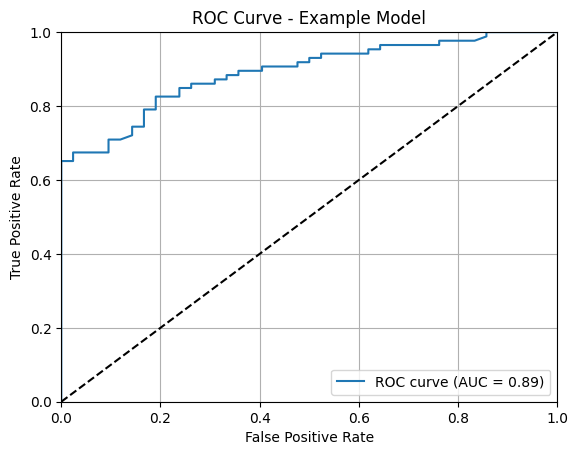

In [12]:
y_pred_proba = RF.predict_proba(test_X)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
roc_auc = roc_auc_score(test_y, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Example Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Step 10: Evaluate Different Thresholds and Plot ROC Curve
- Custom Thresholds: Evaluate the model at different thresholds by converting predicted probabilities to binary predictions based on these thresholds. Calculate:
  - accuracy
  - precision
  - recall
  - F1-score
  - ROC AUC.
- Display Metrics: Print the metrics and confusion matrices for each threshold. Store metrics in a DataFrame and plot them.
- ROC Curve: Plot the ROC curve using the predicted probabilities from the best model and display the AUC value.

Threshold results:

| Threshold | Accuracy | Precision | Recall  | F1-score | ROC AUC |
|-----------|----------|-----------|---------|----------|---------|
| 0.4       | 0.742188 | 0.734513  | 0.965116| 0.834171 | 0.891196|
| 0.5       | 0.789062 | 0.792079  | 0.930233| 0.855615 | 0.891196|
| 0.6       | 0.812500 | 0.852273  | 0.872093| 0.862069 | 0.891196|
| 0.7       | 0.781250 | 0.902778  | 0.755814| 0.822785 | 0.891196|
| 0.8       | 0.757812 | 0.982456  | 0.651163| 0.783217 | 0.891196|
| 0.9       | 0.687500 | 1.000000  | 0.534884| 0.696970 | 0.891196|

Based on each metric:

- Accuracy Best Threshold: 0.6
- Precision Best Threshold: 0.9
- Recall Best Threshold: 0.4
- F1-score Best Threshold: 0.6
- ROC AUC Best Threshold: All thresholds have the same value

Balance between these metrics, the threshold of 0.6 is a strong choice, providing high accuracy and F1-score.

Threshold = 0.4
Accuracy: 0.7422, Precision: 0.7345, Recall: 0.9651, F1-score: 0.8342, ROC AUC: 0.8912
Confusion Matrix:
[[12 30]
 [ 3 83]]


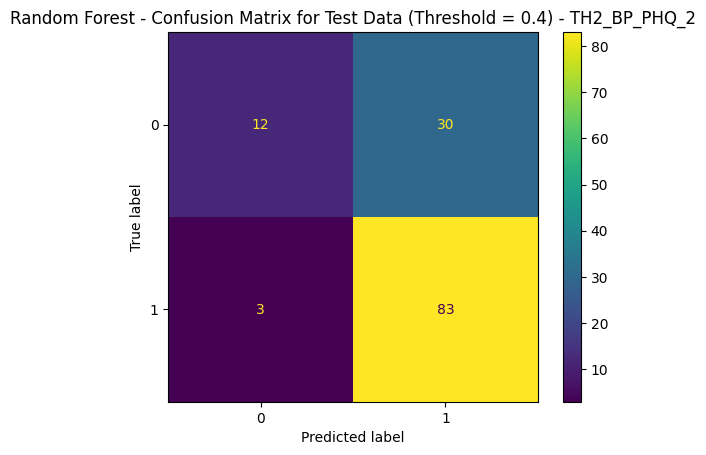

Threshold = 0.5
Accuracy: 0.7891, Precision: 0.7921, Recall: 0.9302, F1-score: 0.8556, ROC AUC: 0.8912
Confusion Matrix:
[[21 21]
 [ 6 80]]


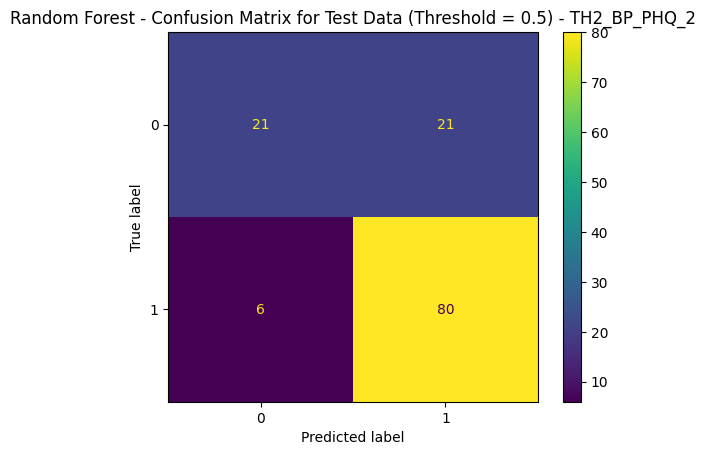

Threshold = 0.6
Accuracy: 0.8125, Precision: 0.8523, Recall: 0.8721, F1-score: 0.8621, ROC AUC: 0.8912
Confusion Matrix:
[[29 13]
 [11 75]]


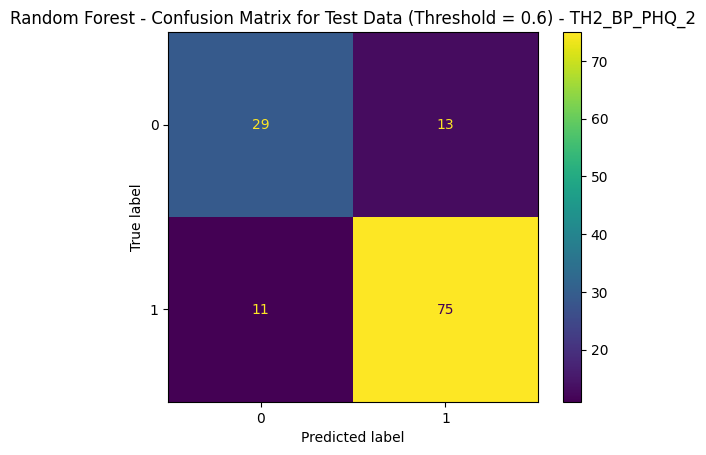

Threshold = 0.7
Accuracy: 0.7812, Precision: 0.9028, Recall: 0.7558, F1-score: 0.8228, ROC AUC: 0.8912
Confusion Matrix:
[[35  7]
 [21 65]]


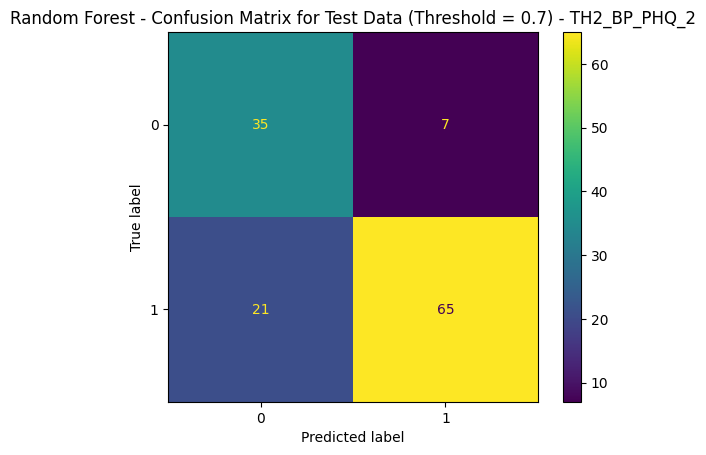

Threshold = 0.8
Accuracy: 0.7578, Precision: 0.9825, Recall: 0.6512, F1-score: 0.7832, ROC AUC: 0.8912
Confusion Matrix:
[[41  1]
 [30 56]]


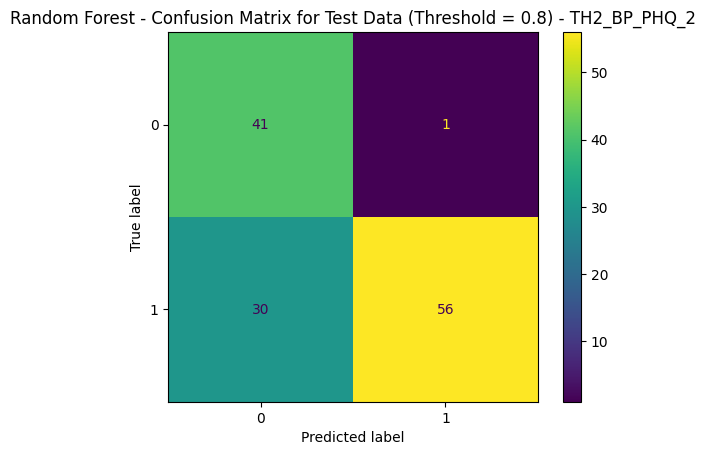

Threshold = 0.9
Accuracy: 0.6875, Precision: 1.0000, Recall: 0.5349, F1-score: 0.6970, ROC AUC: 0.8912
Confusion Matrix:
[[42  0]
 [40 46]]


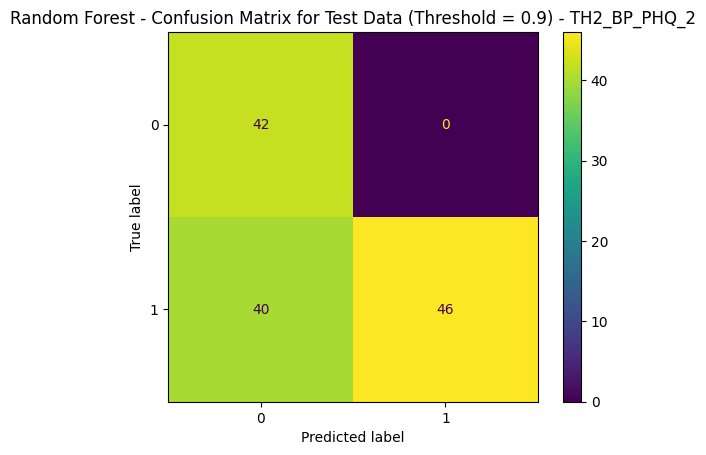

   Threshold  Accuracy  Precision    Recall  F1-score   ROC AUC
0        0.4  0.742188   0.734513  0.965116  0.834171  0.891196
1        0.5  0.789062   0.792079  0.930233  0.855615  0.891196
2        0.6  0.812500   0.852273  0.872093  0.862069  0.891196
3        0.7  0.781250   0.902778  0.755814  0.822785  0.891196
4        0.8  0.757812   0.982456  0.651163  0.783217  0.891196
5        0.9  0.687500   1.000000  0.534884  0.696970  0.891196


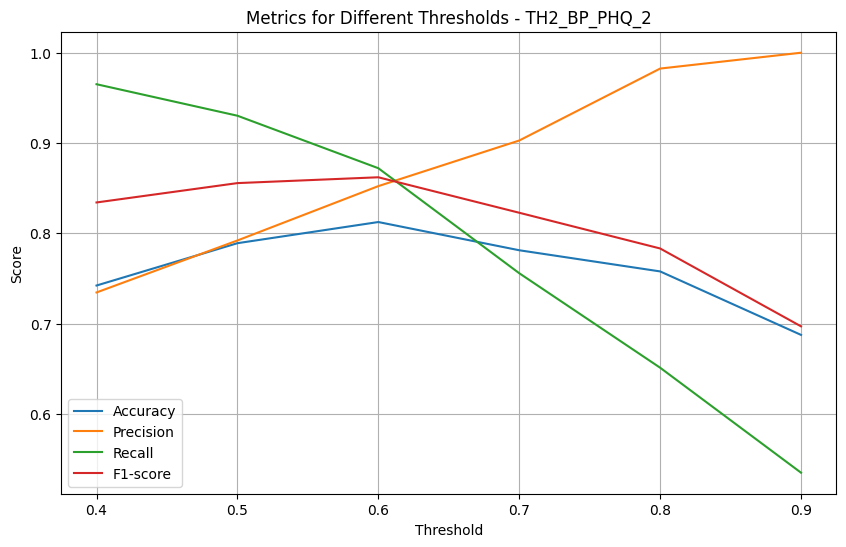

Best Threshold based on F1-score: 0.6


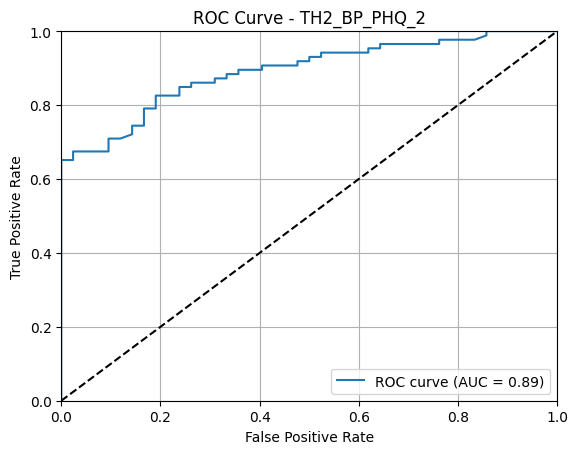

In [13]:
# Use custom thresholds to make predictions and calculate metrics
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y_pred_proba = RF.predict_proba(test_X)[:, 1]

metrics_dict = {
    'Threshold': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'ROC AUC': []
}

roc_auc = roc_auc_score(test_y, y_pred_proba)

for threshold in thresholds:
    pred_y_test_custom = (y_pred_proba >= threshold).astype(int)

    accuracy = accuracy_score(test_y, pred_y_test_custom)
    precision = precision_score(test_y, pred_y_test_custom)
    recall = recall_score(test_y, pred_y_test_custom)
    f1 = f1_score(test_y, pred_y_test_custom)

    metrics_dict['Threshold'].append(threshold)
    metrics_dict['Accuracy'].append(accuracy)
    metrics_dict['Precision'].append(precision)
    metrics_dict['Recall'].append(recall)
    metrics_dict['F1-score'].append(f1)
    metrics_dict['ROC AUC'].append(roc_auc)

    print(f"Threshold = {threshold}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    cm_test_custom = confusion_matrix(test_y, pred_y_test_custom)
    print(cm_test_custom)

    disp_test_custom = ConfusionMatrixDisplay(confusion_matrix=cm_test_custom)
    disp_test_custom.plot()
    plt.title(f'Random Forest - Confusion Matrix for Test Data (Threshold = {threshold}) - {title_results}')
    plt.show()

metrics_df = pd.DataFrame(metrics_dict)
print(metrics_df)

plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Threshold'], metrics_df['Accuracy'], label='Accuracy')
plt.plot(metrics_df['Threshold'], metrics_df['Precision'], label='Precision')
plt.plot(metrics_df['Threshold'], metrics_df['Recall'], label='Recall')
plt.plot(metrics_df['Threshold'], metrics_df['F1-score'], label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'Metrics for Different Thresholds - {title_results}')
plt.legend()
plt.grid()
plt.show()


best_threshold = metrics_df.loc[metrics_df['F1-score'].idxmax(), 'Threshold']
print(f"Best Threshold based on F1-score: {best_threshold}")

# Plot the ROC curve for the best model
y_pred_proba = RF.predict_proba(test_X)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {title_results}')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Step 11: Evaluating the Second Dataset

1. Load Data: Load the second dataset into a DataFrame to prepare for analysis and modeling.

2. Define Features and Target:
Identify and select the relevant features (independent variables) and the target variable (dependent variable) for the model.

3. Split Data: Divide the second dataset into training and testing sets to evaluate the model's performance on unseen data. Typically, 80% of the data is used for training and 20% for testing.

4. Define Parameter Distribution: Specify the hyperparameters and their respective ranges for hyperparameter tuning. This helps in finding the best combination of parameters for the model.

5. Create Classifier: Instantiate the Decision Tree classifier using the best hyperparameters obtained from the hyperparameter tuning process.

6. Cross-Validation Strategy:Define a cross-validation strategy (e.g., K-fold cross-validation) to ensure robust model evaluation during the hyperparameter tuning process.

7. Hyperparameter Tuning: Perform RandomizedSearchCV to find the optimal hyperparameters for the classifier. This involves training multiple models with different parameter combinations and selecting the best one based on a scoring metric.

8. Fit Model: Train the Decision Tree classifier using the training data from the second dataset with the best-found hyperparameters.

9. Make Predictions: Generate predictions for both the training and test data using the trained classifier.

10. Evaluate the Model:
- Precision Score: Compute and print the precision score to evaluate the model's accuracy in predicting positive outcomes.
- Mean Squared Error: Compute and print the mean squared error to assess the overall prediction error.
- Calculate Metrics: Extract and compute additional evaluation metrics such as accuracy, recall, false negative rate, and F1 score.

11. Visualize Performance:
- Confusion Matrix: Generate and display the confusion matrices for both the training and test data to visualize the distribution of true/false positives and negatives.
- AUC and ROC Curve: Compute the Area Under the Curve (AUC) and plot the Receiver Operating Characteristic (ROC) curve to evaluate the classifier's performance. Save the plot for further analysis.

12. Print Metrics: Display all the computed evaluation metrics for a comprehensive assessment of the classifier's performance on the second dataset.

13. Test different Thresholds

In [14]:
# Load the dataset
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100.csv')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_17_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100.csv')

# Keep track of which threshold and version to save results correctly.
# title_results = "TH2_BP_PHQ_2"
title_results = "TH17_MH_PHQ_S"

# Extract the columns with features
columns_with_features = [col for col in data.columns if "FEATURE" in col]

# Define Data and Target for the training process

X = data[['FEATURE_0', 'FEATURE_1', 'FEATURE_4', 'FEATURE_8', 'FEATURE_12', 'FEATURE_16', 'FEATURE_20', 'FEATURE_24', 'FEATURE_28', 'FEATURE_32', 'FEATURE_36', 'FEATURE_40', 'FEATURE_44', 'FEATURE_48', 'FEATURE_52']]
y = data['Depression']
print(X.head)
print(X.shape)

# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=14)

# Define the parameter grid for Randomized Search
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Set up the RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                               n_iter=100, cv=3, verbose=2, random_state=14, n_jobs=-1)

# Fit the model
rf_random.fit(train_X, train_y)

# Check the best parameters and score
best_params = rf_random.best_params_
best_score = rf_random.best_score_
print("Best Parameters:", best_params)
print("Best parameters found: ", rf_random.best_params_)

# Create the Random Forest classifier with the best parameters obtained from hyperparameter tuning
RF = RandomForestClassifier(**best_params)

# Print the best parameters
print("Using the following parameters for the Random Forest classifier:")
for param, value in best_params.items():
    print(f"{param}: {value}")



<bound method NDFrame.head of       FEATURE_0  FEATURE_1  FEATURE_4  FEATURE_8  FEATURE_12  FEATURE_16  \
0      5.122387  -0.431154  -0.431019  -0.167048   -0.096858    1.868558   
1      4.151211  -0.424411  -0.285593  -0.411741   -0.107482    0.100864   
2      5.823771  -0.394454  -0.359670  -0.377060   -0.132813    0.687730   
3      2.063583  -0.451099  -0.433290  -0.086641   -0.199004    0.400605   
4      2.868968  -0.450982  -0.429280  -0.426662   -0.244999    0.719110   
...         ...        ...        ...        ...         ...         ...   
1115   6.402835  -0.361157  -0.339015  -0.239876    0.037329    1.565932   
1116   4.651101  -0.429621  -0.429939  -0.231465   -0.185139    0.764649   
1117   4.588921  -0.456390  -0.442728  -0.227390    0.614065    1.466453   
1118   4.651101  -0.429621  -0.429939  -0.231465   -0.185139    0.764649   
1119   6.485628  -0.339855  -0.337341  -0.311186   -0.121876    1.037260   

      FEATURE_20  FEATURE_24  FEATURE_28  FEATURE_32  FEA

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
Best parameters found:  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
Using the following parameters for the Random Forest classifier:
n_estimators: 500
min_samples_split: 5
min_samples_leaf: 2
max_features: auto
max_depth: 100
bootstrap: True


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Precision Score on training data: 0.9988859689213895


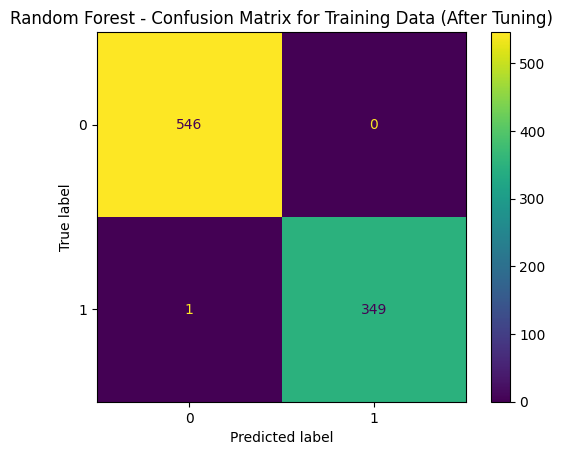

Precision Score on test data: 0.8355663651362575
Mean Squared Error: 0.17857142857142858


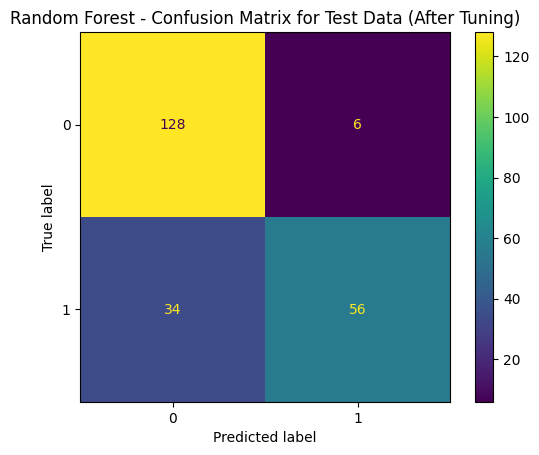

In [15]:
# Fit the model on the training data
RF.fit(train_X, train_y)

# Make predictions on the training data
pred_y_train = RF.predict(train_X)

# Calculate the precision score for training data
precision_train = precision_score(train_y, pred_y_train, average='weighted')
print(f"Precision Score on training data: {precision_train}")

# Generate and display the confusion matrix for training data
cm_train = confusion_matrix(train_y, pred_y_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title('Random Forest - Confusion Matrix for Training Data (After Tuning)')
plt.show()

# Make predictions on the test data
pred_y_test = RF.predict(test_X)

# Calculate the precision score for test data
precision_test = precision_score(test_y, pred_y_test, average='weighted')
print(f"Precision Score on test data: {precision_test}")

# Calculate the Mean Squared Error for test data
mse = mean_squared_error(test_y, pred_y_test)
print(f"Mean Squared Error: {mse}")

# Generate and display the confusion matrix for test data
cm_test = confusion_matrix(test_y, pred_y_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title('Random Forest - Confusion Matrix for Test Data (After Tuning)')
plt.show()

In [16]:
# Extract True Negative, False Positive, False Negative, and True Positive
TN, FP, FN, TP = cm_test.ravel()

# Calculate accuracy, recall, false negative rate, and F1 score
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)  # True positive rate
FNR = FN / (TP + FN)  # False negative rate
f1 = 2 * (precision_test * recall) / (precision_test + recall)  # Use precision_test for consistency

# Print the calculated metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision_test}")  # Use precision_test for consistency
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8214285714285714
Precision: 0.8355663651362575
Recall: 0.6222222222222222
F1 Score: 0.7132830714106532


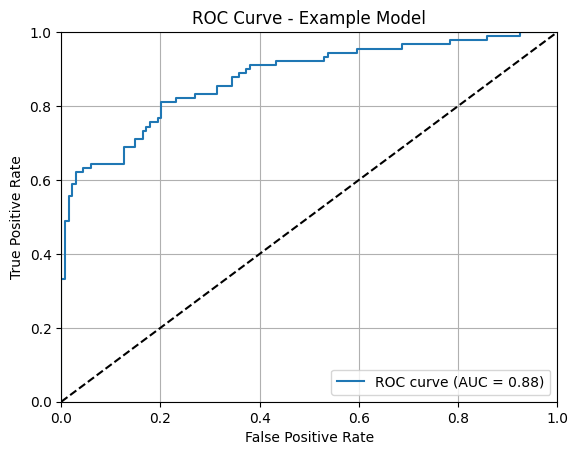

In [17]:
y_pred_proba = RF.predict_proba(test_X)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
roc_auc = roc_auc_score(test_y, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Example Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Result Threshold:

| Threshold | Accuracy | Precision | Recall  | F1-score | ROC AUC |
|-----------|----------|-----------|---------|----------|---------|
| 0.4       | 0.785714 | 0.718750  | 0.766667| 0.741935 | 0.875373|
| 0.5       | 0.821429 | 0.903226  | 0.622222| 0.736842 | 0.875373|
| 0.6       | 0.790179 | 0.957447  | 0.500000| 0.656934 | 0.875373|
| 0.7       | 0.736607 | 0.969697  | 0.355556| 0.520325 | 0.875373|
| 0.8       | 0.700893 | 1.000000  | 0.255556| 0.407080 | 0.875373|
| 0.9       | 0.647321 | 1.000000  | 0.122222| 0.217822 | 0.875373|

Based on each metric:

- Accuracy Best Threshold: 0.5
- Precision Best Threshold: 0.8 and 0.9
- Recall Best Threshold: 0.4
- F1-score Best Threshold: 0.4
- ROC AUC Best Threshold: All thresholds have the same value

Balance between these metrics, the threshold of 0.5 is a strong choice, providing the highest accuracy while maintaining reasonable precision and recall.

Choosing a threshold involves balancing these metrics according to your specific needs. If capturing more positive instances (higher recall) and maintaining a good balance (F1-score) are priorities, 0.4 is indeed a very good choice.

Threshold = 0.4
Accuracy: 0.7857, Precision: 0.7188, Recall: 0.7667, F1-score: 0.7419, ROC AUC: 0.8754
Confusion Matrix:
[[107  27]
 [ 21  69]]


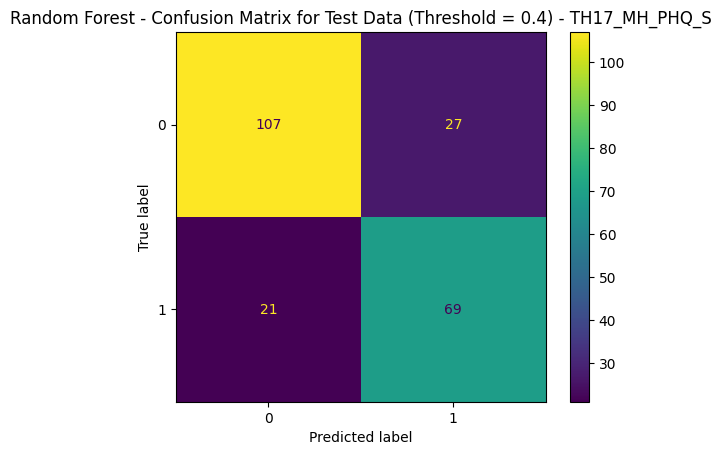

Threshold = 0.5
Accuracy: 0.8214, Precision: 0.9032, Recall: 0.6222, F1-score: 0.7368, ROC AUC: 0.8754
Confusion Matrix:
[[128   6]
 [ 34  56]]


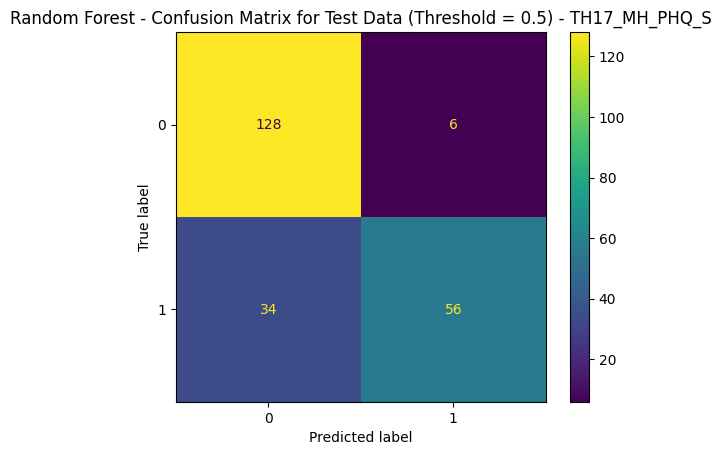

Threshold = 0.6
Accuracy: 0.7902, Precision: 0.9574, Recall: 0.5000, F1-score: 0.6569, ROC AUC: 0.8754
Confusion Matrix:
[[132   2]
 [ 45  45]]


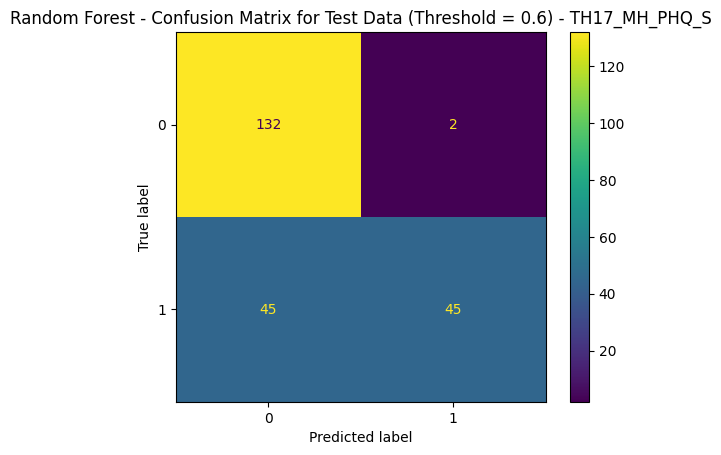

Threshold = 0.7
Accuracy: 0.7366, Precision: 0.9697, Recall: 0.3556, F1-score: 0.5203, ROC AUC: 0.8754
Confusion Matrix:
[[133   1]
 [ 58  32]]


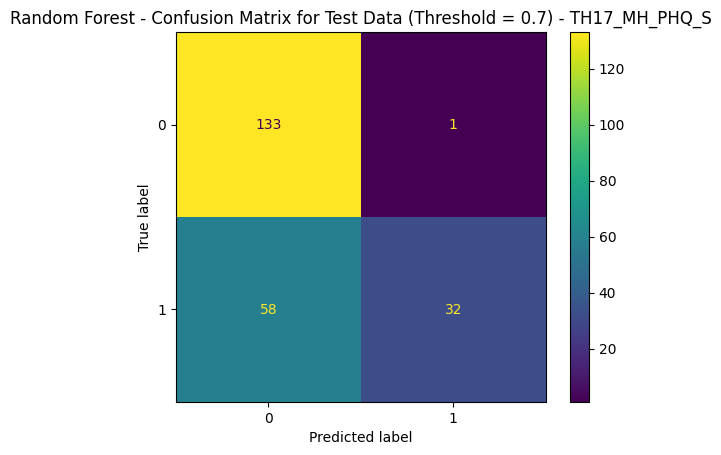

Threshold = 0.8
Accuracy: 0.7009, Precision: 1.0000, Recall: 0.2556, F1-score: 0.4071, ROC AUC: 0.8754
Confusion Matrix:
[[134   0]
 [ 67  23]]


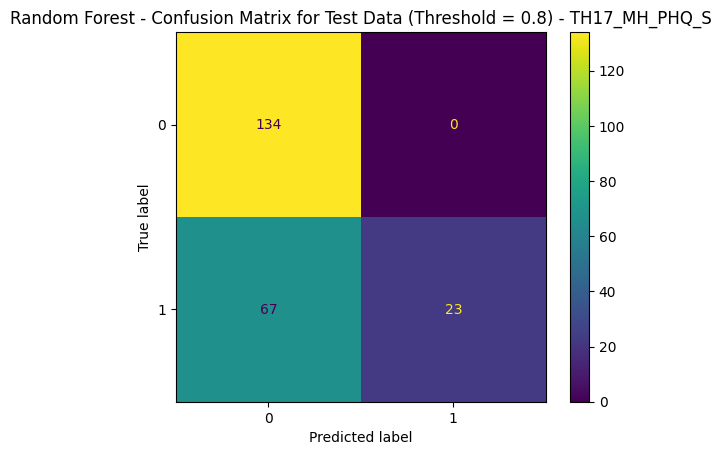

Threshold = 0.9
Accuracy: 0.6473, Precision: 1.0000, Recall: 0.1222, F1-score: 0.2178, ROC AUC: 0.8754
Confusion Matrix:
[[134   0]
 [ 79  11]]


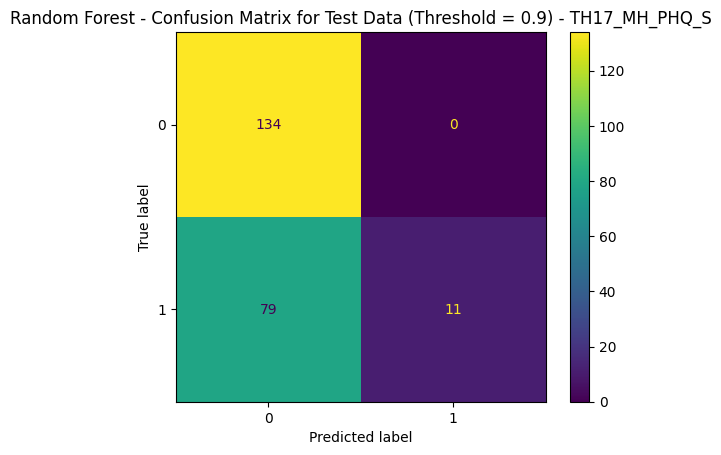

   Threshold  Accuracy  Precision    Recall  F1-score   ROC AUC
0        0.4  0.785714   0.718750  0.766667  0.741935  0.875373
1        0.5  0.821429   0.903226  0.622222  0.736842  0.875373
2        0.6  0.790179   0.957447  0.500000  0.656934  0.875373
3        0.7  0.736607   0.969697  0.355556  0.520325  0.875373
4        0.8  0.700893   1.000000  0.255556  0.407080  0.875373
5        0.9  0.647321   1.000000  0.122222  0.217822  0.875373


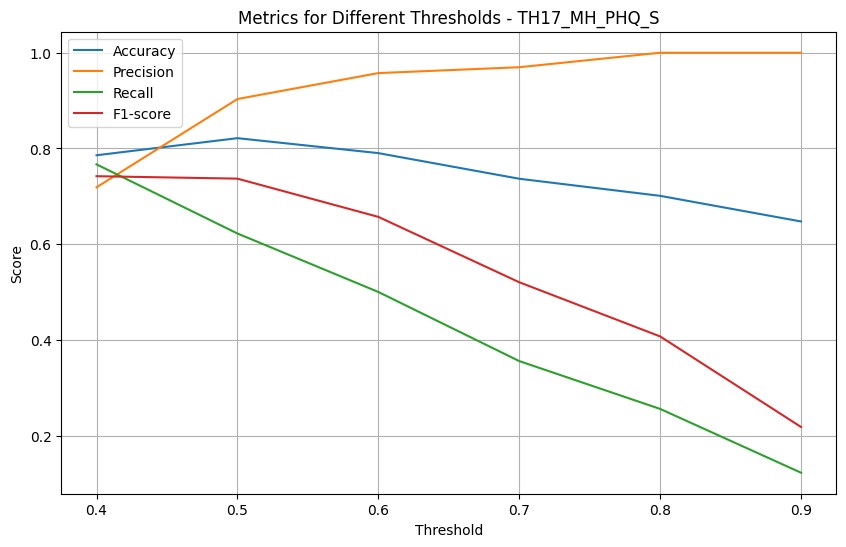

Best Threshold based on F1-score: 0.4


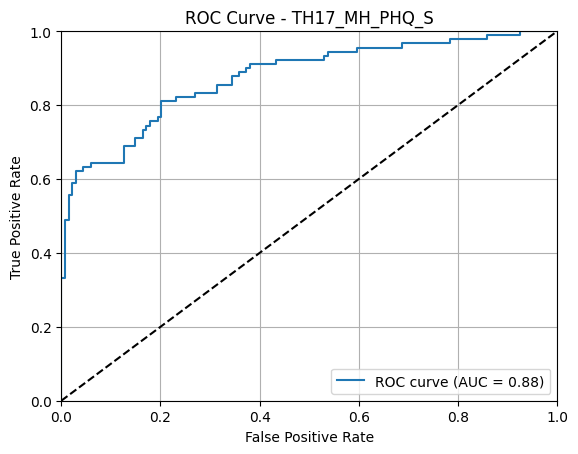

In [18]:
# Use custom thresholds to make predictions and calculate metrics
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y_pred_proba = RF.predict_proba(test_X)[:, 1]

metrics_dict = {
    'Threshold': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'ROC AUC': []
}

roc_auc = roc_auc_score(test_y, y_pred_proba)

for threshold in thresholds:
    pred_y_test_custom = (y_pred_proba >= threshold).astype(int)

    accuracy = accuracy_score(test_y, pred_y_test_custom)
    precision = precision_score(test_y, pred_y_test_custom)
    recall = recall_score(test_y, pred_y_test_custom)
    f1 = f1_score(test_y, pred_y_test_custom)

    metrics_dict['Threshold'].append(threshold)
    metrics_dict['Accuracy'].append(accuracy)
    metrics_dict['Precision'].append(precision)
    metrics_dict['Recall'].append(recall)
    metrics_dict['F1-score'].append(f1)
    metrics_dict['ROC AUC'].append(roc_auc)

    print(f"Threshold = {threshold}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    cm_test_custom = confusion_matrix(test_y, pred_y_test_custom)
    print(cm_test_custom)

    disp_test_custom = ConfusionMatrixDisplay(confusion_matrix=cm_test_custom)
    disp_test_custom.plot()
    plt.title(f'Random Forest - Confusion Matrix for Test Data (Threshold = {threshold}) - {title_results}')
    plt.show()

metrics_df = pd.DataFrame(metrics_dict)
print(metrics_df)

plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Threshold'], metrics_df['Accuracy'], label='Accuracy')
plt.plot(metrics_df['Threshold'], metrics_df['Precision'], label='Precision')
plt.plot(metrics_df['Threshold'], metrics_df['Recall'], label='Recall')
plt.plot(metrics_df['Threshold'], metrics_df['F1-score'], label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'Metrics for Different Thresholds - {title_results}')
plt.legend()
plt.grid()
plt.show()


best_threshold = metrics_df.loc[metrics_df['F1-score'].idxmax(), 'Threshold']
print(f"Best Threshold based on F1-score: {best_threshold}")

# Plot the ROC curve for the best model
y_pred_proba = RF.predict_proba(test_X)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {title_results}')
plt.legend(loc='lower right')
plt.grid()
plt.show()
